# Media comparison

This serves as an overview script of my workflow for data generated with a plate reader which hopefully enables me to partially automate that process.

But I also want to reuse code that I wrote and compensate for the lack of documentation in the python script (to keep me sane :D). 

*13.10.2022*

## Imports and general settings

In [4]:
# imports
from utils import *
import pandas as pd
import numpy as np # for calculating standard deviation and mean
import scipy.stats as sp # for calculating standard error
import matplotlib.pyplot as plt
import matplotlib
#from pylatex import Figure, NoEscape, Subsubsection
#from pylatex.utils import italic
import os
from sklearn import metrics
from scipy.optimize.minpack import curve_fit
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#matplotlib.style.use('seaborn-poster')
matplotlib.rcParams.update({'errorbar.capsize': 2})
#matplotlib.rcParams.update({'font.size': 18})
#matplotlib.rcParams.update({'font.family': 'serif'})
matplotlib.rcParams['figure.dpi'] = 180
matplotlib.rcParams['savefig.dpi'] = 180
matplotlib.rcParams['lines.linewidth'] = 2 

#plt.style.use(['science','grid', 'muted'])
matplotlib.rcParams['lines.linewidth'] = 2.5

# set colorstandards to fit to labnotebook
colorstandards = {'14':'tab:cyan', '15':'g', '16':'darksalmon', '17': 'goldenrod'}
markers = ["D", "x", "o",  "H", "d", "p", "H",  "*"]
cb = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

%run -i PARAMS.py
from PARAMS import *
%run -i utils.py

## Focus: One medium for different strains

### Average all measurements per strain

Multiple measurements were made at different time points using the same medium. To get a general overview on how the strains behave these measurements can be averaged using a list of media of interest. As done below the averaged biological replicates from one plate are taken into account as one measurement. The first part collects all data into the dictionary `all_exp_by_medium`.

In [9]:
path_to_excel = '../data/raw/'
#media = ['M9', 'TSB', 'BHI', 'RPMI', 'RPMI', 'SNM(+Vit)', 'SNM+Vit+Trace', 'M9+CasA', 'SNM+CasA']
media = ['CGXII', 'CGXII+CasA']

all_exp_by_medium = {}
for medium in media:
    strains = {}
    for date, layout in convert_layout().items():
        if date == '2022-06-14' or date == '2023-01-27':
            excel_file = str(date) + '_14.xlsx'
        elif date == '2022-06-10' or date == '2023-02-06':
            excel_file = str(date) + '_15.xlsx'
        elif date == '2022-06-15' or date == '2023-02-01':
            excel_file = str(date) + '_16.xlsx'
        elif date == '2022-06-28' or date == '2023-02-03':
            excel_file = str(date) + '_17.xlsx'
        else:
            excel_file = str(date) + '_all.xlsx'
        nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
        df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
        growth, df_errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)

        for strain, curves in growth.items():
            if len(strain) > 2:
                pass
            else:
                if strain not in strains:
                    strains[strain] = pd.DataFrame(curves['Time'])
                    try:
                        strains[strain][medium + ' ' + str(date)] = curves[medium]
                    except (KeyError):
                        #print(medium + ' not there')
                        pass
                elif strain in strains:
                    try:
                        strains[strain][medium + ' ' + str(date)] = curves[medium]
                    except (KeyError):
                        #print(medium + ' not there')
                        pass
    all_exp_by_medium[medium] = strains

Afterwards the data of one strain on one medium can be averaged and then plotted into a plot with the averages of the other media.

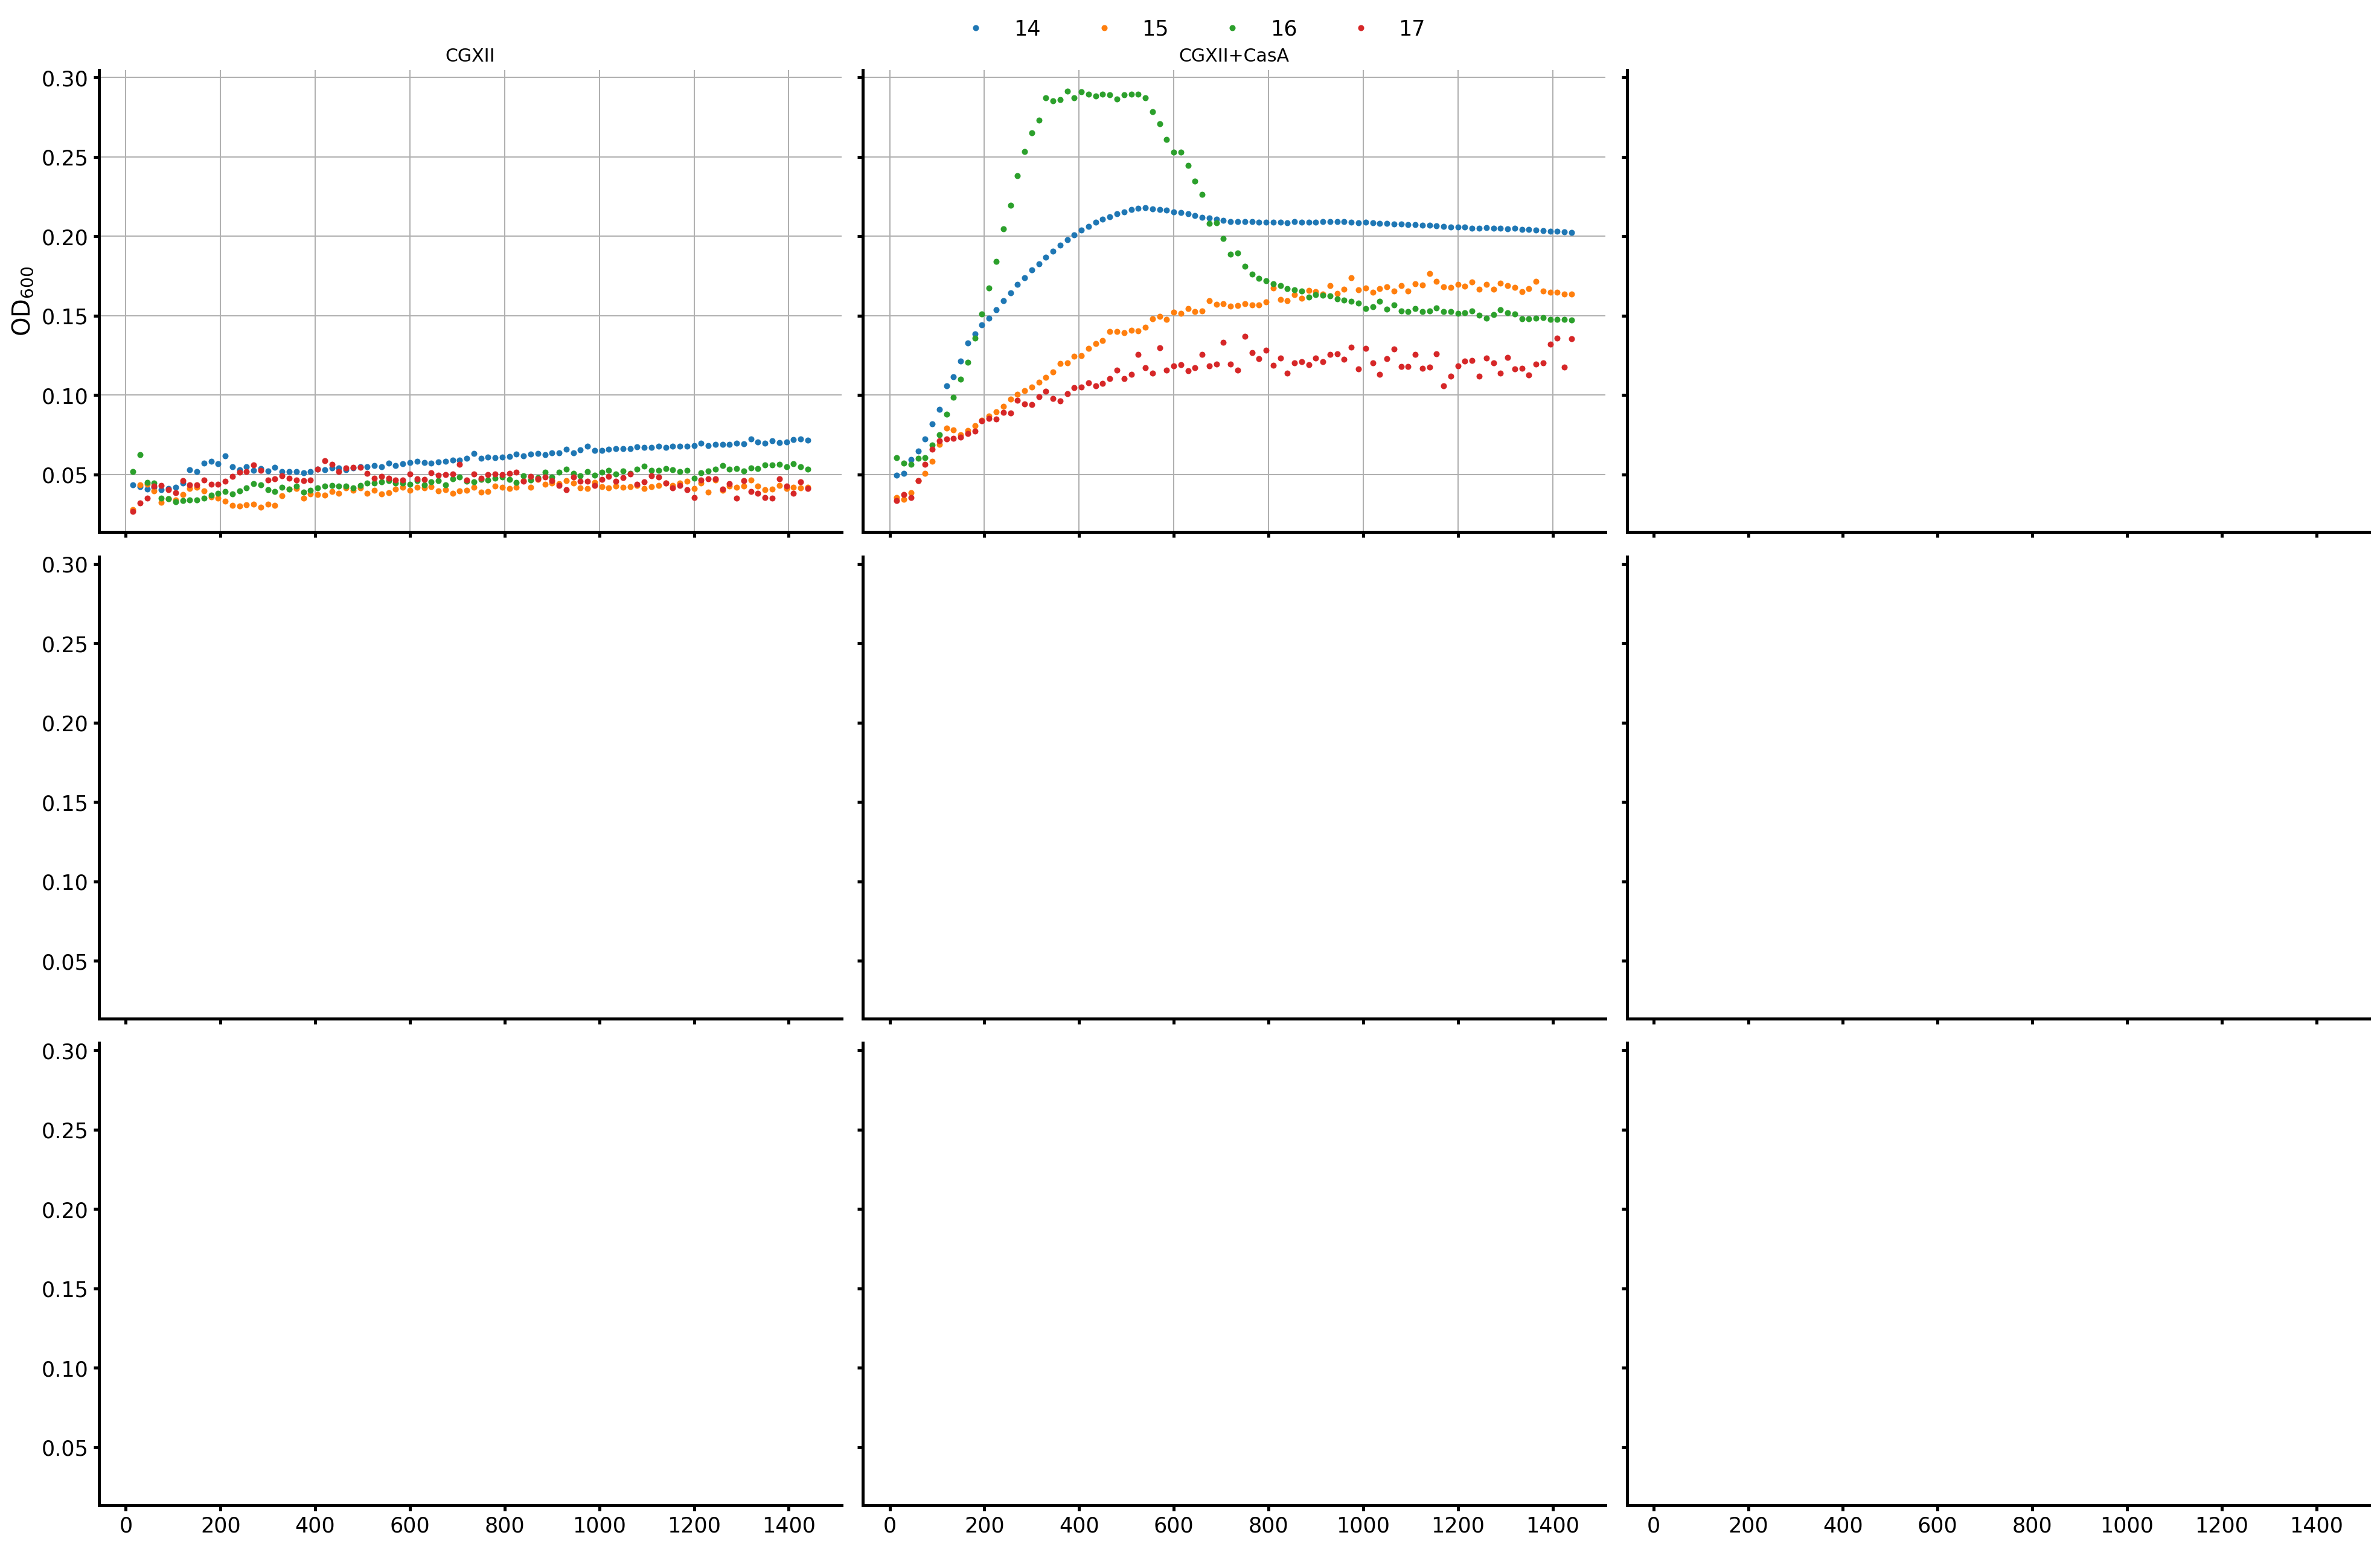

In [12]:
plt.close('all')
plot_number = 0
fig, axs = plt.subplots(3,3, figsize=(22, 14), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
media_avg = {}

for medium, strains in  all_exp_by_medium.items():
    medium_avg = pd.DataFrame()
    for strain, data in strains.items():
        medium_avg['Time'] = data['Time']
        data['mean'] = data.drop('Time', axis=1).mean(axis=1)
        medium_avg[strain] = data['mean']
    media_avg[medium] = medium_avg   

    # medium_avg will always be exported to a csv -> updates when avg changes otherwise csv stays the same
    medium_avg.to_csv('../data/media_avg/' + medium + '.csv', index=False)
    medium_avg.plot(grid=True, 
                x="Time",
                style = '.',
                xlabel='time [min]',
                ylabel='OD$_{600}$',
                title = medium,
                ax=axs[plot_number],
                legend=False,
                #color=colorstandards,
                #logy=True,
                #logx=True
                )
    handles, labels = axs[plot_number].get_legend_handles_labels()
    plot_number += 1
   
plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(0, 0.95, 1, .102), loc='center', ncol=4)

In [14]:
pd.read_csv('../data/media_avg/TSB.csv')

,Time,14,15,16,17
0,15.0,0.009444,0.011222,0.012333,0.011667
1,30.0,0.011250,0.011750,0.014111,0.014028
2,45.0,0.013750,0.013333,0.016833,0.017417
3,60.0,0.017944,0.014417,0.022472,0.022417
4,75.0,0.022444,0.015889,0.027889,0.026750
...,...,...,...,...,...
91,1380.0,0.782028,0.369639,0.913389,0.492694
92,1395.0,0.783389,0.369333,0.914306,0.489944
93,1410.0,0.782556,0.370500,0.915972,0.489917
94,1425.0,0.782139,0.371722,0.917083,0.487917


For the log-phase transfer when testing binary growth phenotypes we are interested in the growth behaviour on TSB.

In [15]:
medium = 'CGXII+CasA'
for strain, df in all_exp_by_medium[medium].items():
    df['mean'] = df.drop('Time', inplace=False, axis=1).mean(axis=1)
    df['err'] = df.drop('Time', inplace=False, axis=1).std(axis=1)

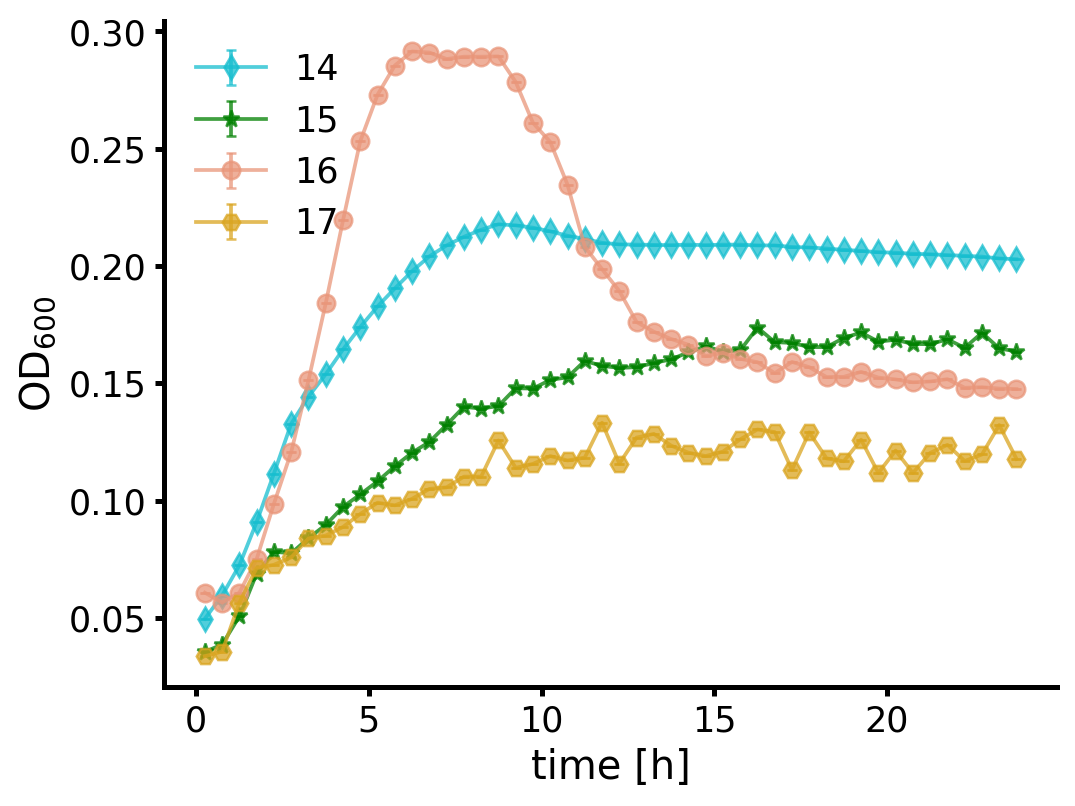

<Figure size 1152x864 with 0 Axes>

In [16]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
}):
    i = 0
    for strain, dataframe in all_exp_by_medium[medium].items():
        plt.errorbar(dataframe['Time'][::2] / 60, dataframe['mean'][::2], yerr=dataframe['err'][::2], 
                     marker=markers[i], color=colorstandards[strain], label=strain, linewidth=1.5, alpha=0.75,
                                         capsize=2.0, 
                                         markersize=7)
        i+=1
    #plt.xticks(np.arange(0,10.5, 1)) #24.5,4))
    #plt.axvspan(4.5, 6.5, facecolor='k', alpha=0.15)
    #plt.xlim(0,10.5)
    plt.xlabel('time [h]', fontsize=16)
    plt.ylabel(r'OD$_{600}$', fontsize=16)
    plt.legend(frameon=False)#,fontsize=8,  bbox_to_anchor=(-0.10, 1.15), loc='upper left', ncol=4, mode="expand", borderaxespad=0., fontsize=12)
    plt.show()

    plt.tight_layout()

## Focus: One medium from biological replicates

To see whether the errorbars from the whole averaging are also happening with the biological replicates.

#### TSB

In [33]:
tsb_14 = pd.read_csv('../data/media_avg/TSB_14.csv', index_col=0)
tsb_15 = pd.read_csv('../data/media_avg/TSB_15.csv', index_col=0)
tsb_16 = pd.read_csv('../data/media_avg/TSB_16.csv', index_col=0)
tsb_17 = pd.read_csv('../data/media_avg/TSB_17.csv', index_col=0)
time = pd.read_csv('../data/media_avg/time.csv', index_col=0)
time = time.iloc[0:96]
tsb_15 = tsb_15.iloc[0:96]
dfs_tsb = {14:tsb_14, 15:tsb_15, 16:tsb_16, 17:tsb_17}


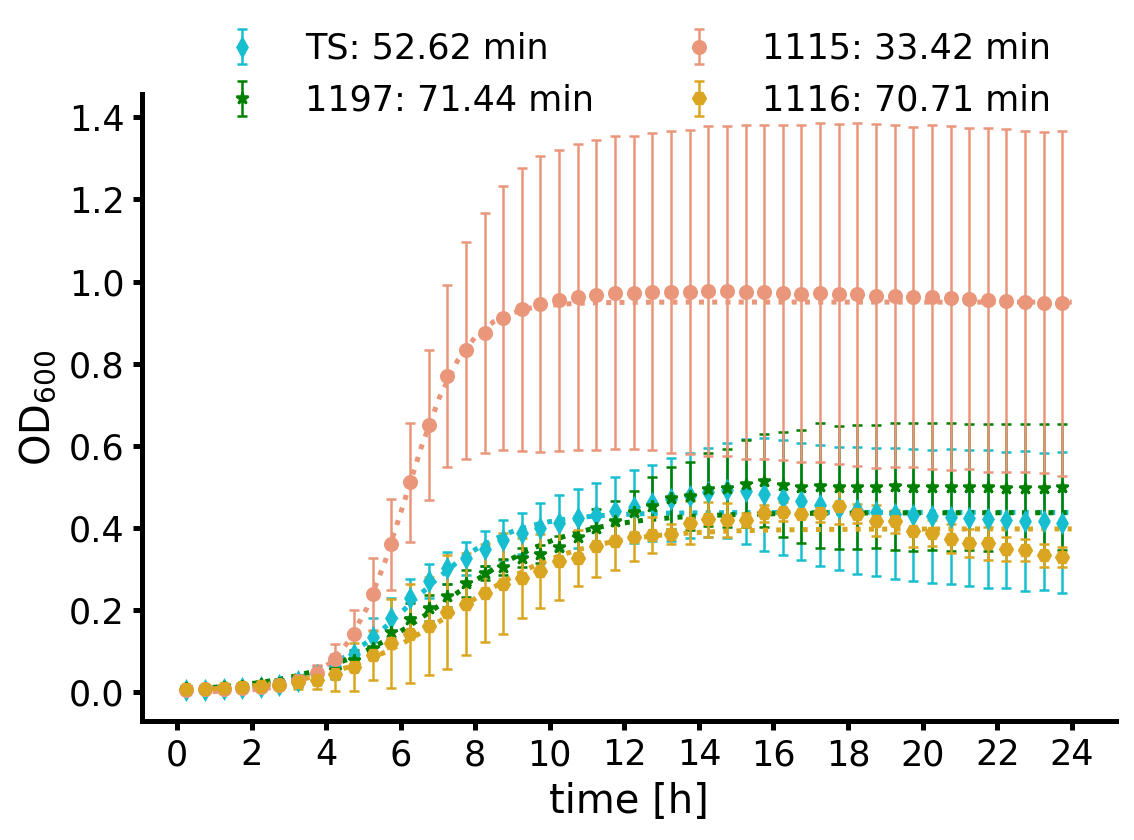

In [38]:
i = 0
labels = {14: '14', 15: '15', 16: '16', 17:'17'} #{14: 'TS', 15: '1197', 16: '1115', 17:'1116'}
t = np.linspace(time['mean'].min()/60, time['mean'].max()/60)
aucs_tsb = {}
for strain in [14,15,16,17]:
    df = dfs_tsb[strain]
    auc = metrics.auc(time['mean'], df['mean'])
    aucs_tsb[strain] = auc
    popts, pcovs = curve_fit(logistic, time['mean']/60, df['mean'], np.asarray([0.2,0.05,0.05]))
    if strain == 16:
        popts, pcovs = curve_fit(logistic, time['mean'][:40]/60, df['mean'][:40], np.asarray([0.2,0.05,0.05]))
    if strain == 14 or strain == 15:
        popts, pcovs = curve_fit(logistic, time['mean'][:50]/60, df['mean'][:50], np.asarray([0.2,0.05,0.05]))#([0.5,0.5,0.002]))
    dt = round((np.log(2)/popts[2])*60,2)
    labels[strain] = STRAINS_LAB[labels[strain]] + ': ' + str(dt) + ' min'
    plt.errorbar(time['mean'][::2] / 60, df['mean'][::2], yerr=df['double_std'][::2], 
                marker=markers[i], 
                color=colorstandards[str(strain)], 
                label=labels[strain], 
                fmt='.',
                ms=5,
                linewidth=1.0,
                )
    plt.plot(t, logistic(t, *popts),
                color=colorstandards[str(strain)], 
                linestyle=':',
                linewidth=2.0, )
    i+=1
plt.xticks(np.arange(0,24.5, 2))
plt.yticks(np.arange(0,1.6, 0.2))
#plt.xlim(0,15)
plt.xlabel('time [h]', fontsize=16)
plt.ylabel(r'OD$_{600}$', fontsize=16)
plt.legend(frameon=False,  bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=14)

plt.tight_layout()
plt.savefig('../figures/TSB_biorep.png')

#### BHI

In [36]:
bhi_14 = pd.read_csv('../data/media_avg/BHI_14.csv', index_col=0)
bhi_15 = pd.read_csv('../data/media_avg/BHI_15.csv', index_col=0)
bhi_16 = pd.read_csv('../data/media_avg/BHI_16.csv', index_col=0)
bhi_17 = pd.read_csv('../data/media_avg/BHI_17.csv', index_col=0)
time = pd.read_csv('../data/media_avg/time.csv', index_col=0)
time = time.iloc[0:96]
bhi_15 = bhi_15.iloc[0:96]
dfs_bhi = {14:bhi_14, 15:bhi_15, 16:bhi_16, 17:bhi_17}

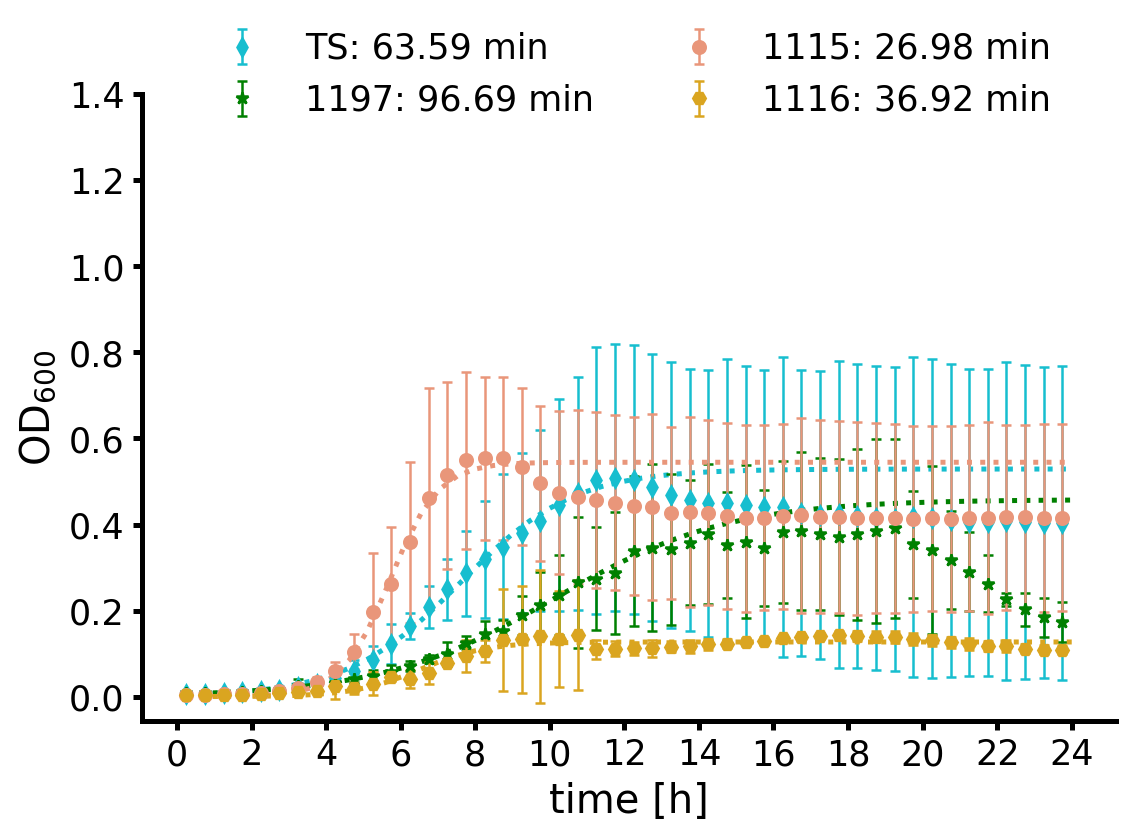

In [37]:
i = 0
labels = {14: '14', 15: '15', 16: '16', 17:'17'} #{14: 'TS', 15: '1197', 16: '1115', 17:'1116'}
t = np.linspace(time['mean'].min()/60, time['mean'].max()/60)
aucs_bhi = {}
for strain in [14,15,16,17]:
    df = dfs_bhi[strain]
    auc = metrics.auc(time['mean'], df['mean'])
    aucs_bhi[strain] = auc
    popts, pcovs = curve_fit(logistic, time['mean']/60, df['mean'], np.asarray([0.2,0.05,0.05]))
    if strain == 16:
        popts, pcovs = curve_fit(logistic, time['mean'][:40]/60, df['mean'][:40], np.asarray([0.2,0.05,0.05]))
    if strain == 14 or strain == 15:
        popts, pcovs = curve_fit(logistic, time['mean'][:50]/60, df['mean'][:50], np.asarray([0.2,0.05,0.05]))#([0.5,0.5,0.002]))
    dt = round((np.log(2)/popts[2])*60,2)
    labels[strain] = STRAINS_LAB[labels[strain]] + ': ' + str(dt) + ' min'
    plt.errorbar(time['mean'][::2] / 60, df['mean'][::2], yerr=df['double_std'][::2], 
                marker=markers[i], 
                color=colorstandards[str(strain)], 
                label=labels[strain], 
                fmt='.',
                ms=5,
                linewidth=1.0,
                )
    plt.plot(t, logistic(t, *popts),
                color=colorstandards[str(strain)], 
                linestyle=':',
                linewidth=2.0, )
    i+=1
plt.xticks(np.arange(0,24.5, 2))
plt.yticks(np.arange(0,1.6, 0.2))
#plt.xlim(0,15)
plt.xlabel('time [h]', fontsize=16)
plt.ylabel(r'OD$_{600}$', fontsize=16)
plt.legend(frameon=False,  bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=14)

plt.tight_layout()
plt.savefig('../figures/BHI_biorep.png')

**Area under curve tables**

In [31]:
auc_df = pd.DataFrame.from_dict(aucs_bhi, orient='index').rename({0:'AUC [BHI]'}, axis=1)
auc_df['AUC [TSB]'] = pd.DataFrame.from_dict(aucs_tsb, orient='index').rename({0:'AUC [TSB]'}, axis=1)['AUC [TSB]']
print(auc_df.reset_index().astype({'index':str}).replace(STRAINS_LAB).rename({'index': 'strain'}, axis=1).round(2).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
strain &  AUC [BHI] &  AUC [TSB] \\
\midrule
    TS &     451.17 &     471.28 \\
  1197 &     308.20 &     482.85 \\
  1115 &     499.70 &    1032.72 \\
  1116 &     134.96 &     393.42 \\
\bottomrule
\end{tabular}



#### LB

In [25]:
lb_14 = pd.read_csv('../data/media_avg/LB_14.csv', index_col=0)
lb_15 = pd.read_csv('../data/media_avg/LB_15.csv', index_col=0)
lb_16 = pd.read_csv('../data/media_avg/LB_16.csv', index_col=0)
lb_17 = pd.read_csv('../data/media_avg/LB_17.csv', index_col=0)
time = pd.read_csv('../data/media_avg/time.csv', index_col=0)
time = time.iloc[0:96]
lb_15 = lb_15.iloc[0:96]
dfs = {14:lb_14, 15:lb_15, 16:lb_16, 17:lb_17}

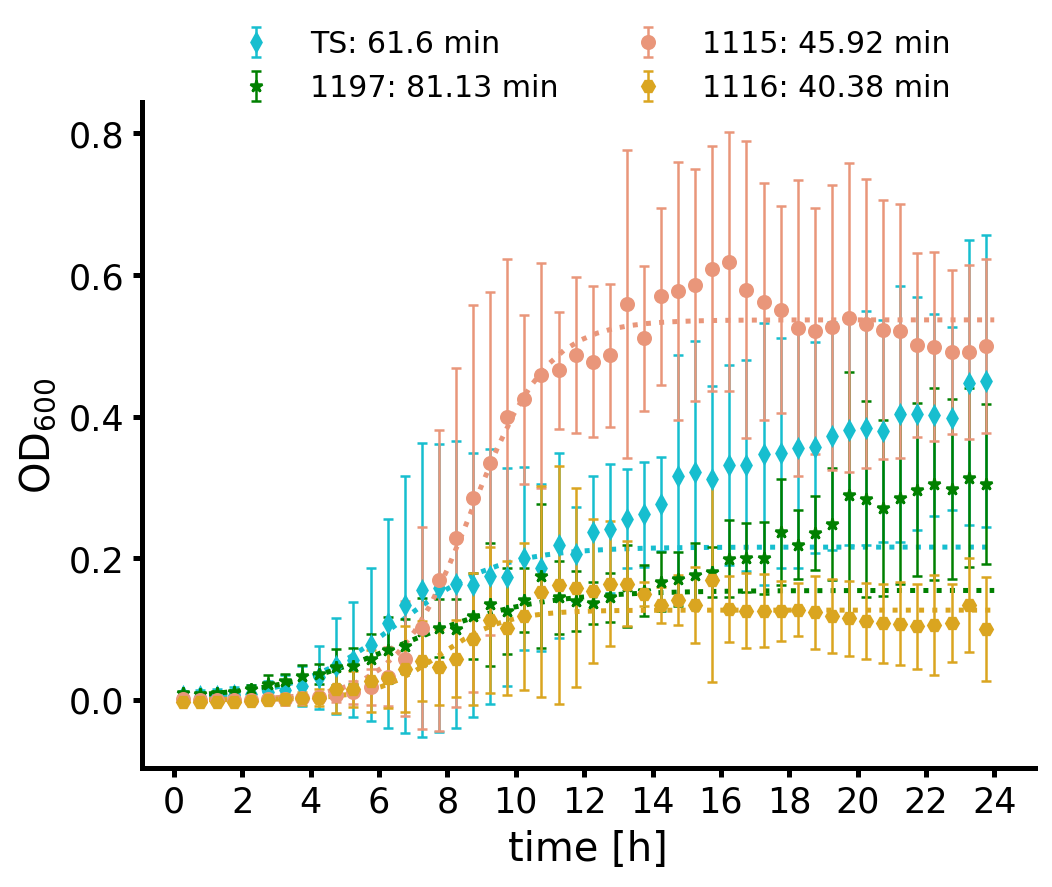

In [26]:
i = 0
labels = {14: '14', 15: '15', 16: '16', 17:'17'} #{14: 'TS', 15: '1197', 16: '1115', 17:'1116'}
t = np.linspace(time['mean'].min()/60, time['mean'].max()/60)
aucs_lb = {}
for strain in [14,15,16,17]:
    df = dfs[strain]
    auc = metrics.auc(time['mean'], df['mean'])
    aucs_lb[strain] = auc
    popts, pcovs = curve_fit(logistic, time['mean']/60, df['mean'], np.asarray([0.2,0.05,0.05]))
    if strain == 14 or strain == 15:
        popts, pcovs = curve_fit(logistic, time['mean'][:50]/60, df['mean'][:50], np.asarray([0.2,0.05,0.05]))#([0.5,0.5,0.002]))
    dt = round((np.log(2)/popts[2])*60,2)
    labels[strain] = STRAINS_LAB[labels[strain]] + ': ' + str(dt) + ' min'
    plt.errorbar(time['mean'][::2] / 60, df['mean'][::2], yerr=df['double_std'][::2], 
                marker=markers[i], 
                color=colorstandards[str(strain)], 
                label=labels[strain], 
                fmt='.',
                ms=5,
                linewidth=1.0,
                )
    plt.plot(t, logistic(t, *popts),
                color=colorstandards[str(strain)], 
                linestyle=':',
                linewidth=2.0, )
    i+=1
plt.xticks(np.arange(0,24.5, 2))
plt.yticks(np.arange(0,1.0, 0.2))
plt.xlabel('time [h]', fontsize=16)
plt.ylabel(r'OD$_{600}$', fontsize=16)
plt.legend(frameon=False,  bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=12)

plt.savefig('../figures/LB_biorep.png', bbox_inches='tight')

In [ ]:
# OD fold change
for strain in [14,15,16,17]:
    df = dfs[strain]
    t0 = abs(df.loc[0]['mean'])
    t24 = abs(df.loc[95]['mean'])
    t0_err = abs(df.loc[0]['double_std']) / 2
    t24_err = abs(df.loc[95]['double_std']) / 2
    fold = t24/t0
    fold_err = (abs(t24_err/t24))+(abs(t0_err/t0))
    print(str(strain) + ': ' + str(round(fold, 2)) + ' err ' + str(round(fold_err, 2)))

14: 92.07 err 1.04
15: 34.39 err 0.37
16: 1114.5 err 2.6
17: 27.13 err 0.56


In [ ]:
dates = [220517, 220531, 220609]


### RPMI

In [25]:
rpmi_14 = pd.read_csv('../data/media_avg/RPMI_14.csv', index_col=0)
rpmi_15 = pd.read_csv('../data/media_avg/RPMI_15.csv', index_col=0)
rpmi_16 = pd.read_csv('../data/media_avg/RPMI_16.csv', index_col=0)
rpmi_17 = pd.read_csv('../data/media_avg/RPMI_17.csv', index_col=0)
time = pd.read_csv('../data/media_avg/time.csv', index_col=0)
time = time.iloc[0:96]
rpmi_15 = rpmi_15.iloc[0:96]
dfs_rpmi = {14:rpmi_14, 15:rpmi_15, 16:rpmi_16, 17:rpmi_17}

In [32]:
print(dfs_rpmi[17]['double_std'].max())

0.3706835860780111


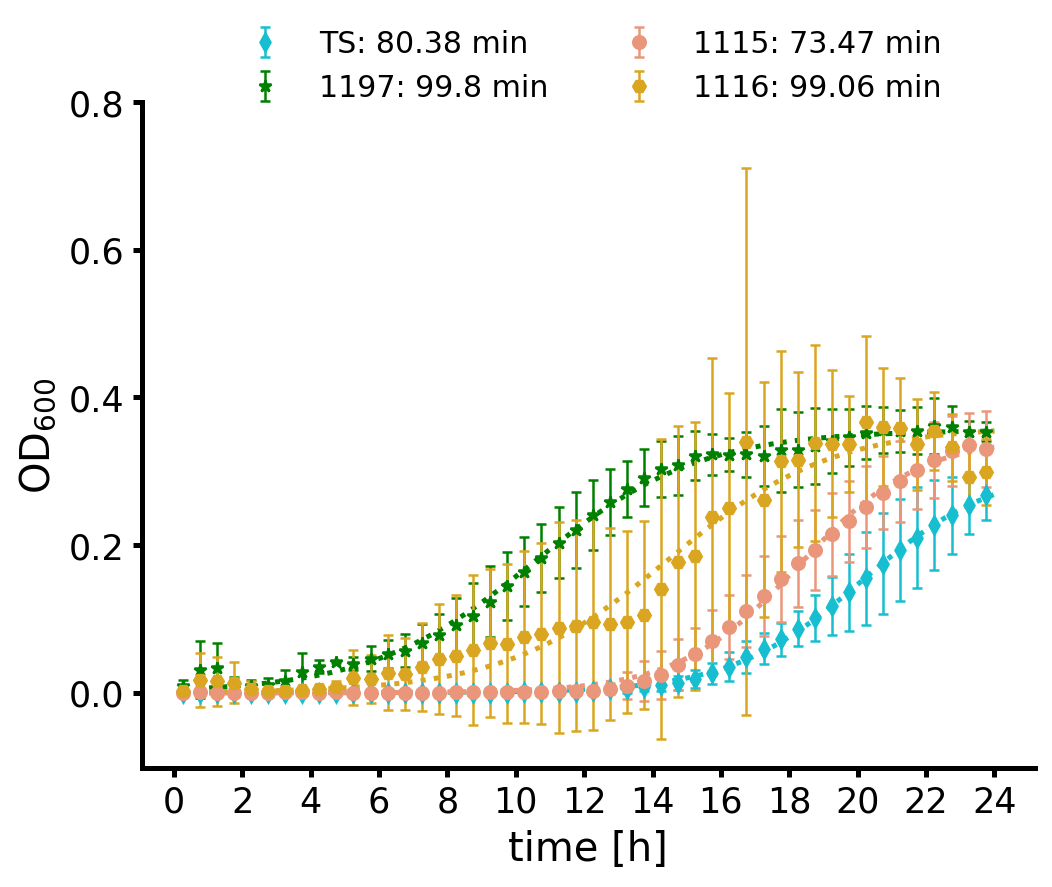

In [28]:
i = 0
labels = {14: '14', 15: '15', 16: '16', 17:'17'} #{14: 'TS', 15: '1197', 16: '1115', 17:'1116'}
t = np.linspace(time['mean'].min()/60, time['mean'].max()/60)
aucs_rpmi = {}
for strain in [14,15,16,17]:
    df = dfs_rpmi[strain]
    auc = metrics.auc(time['mean'], df['mean'])
    aucs_rpmi[strain] = auc
    popts, pcovs = curve_fit(logistic, time['mean']/60, df['mean'], np.asarray([0.2,0.05,0.05]))
    #if strain == 14 or strain == 15:
    #    popts, pcovs = curve_fit(logistic, time['mean'][:50]/60, df['mean'][:50], np.asarray([0.2,0.05,0.05]))#([0.5,0.5,0.002]))
    dt = round((np.log(2)/popts[2])*60,2)
    labels[strain] = STRAINS_LAB[labels[strain]] + ': ' + str(dt) + ' min'
    plt.errorbar(time['mean'][::2] / 60, df['mean'][::2], yerr=df['double_std'][::2], 
                marker=markers[i], 
                color=colorstandards[str(strain)], 
                label=labels[strain], 
                fmt='.',
                ms=5,
                linewidth=1.0,
                )
    plt.plot(t, logistic(t, *popts),
                color=colorstandards[str(strain)], 
                linestyle=':',
                linewidth=2.0, )
    i+=1
plt.xticks(np.arange(0,24.5, 2))
plt.yticks(np.arange(0,1.0, 0.2))
plt.xlabel('time [h]', fontsize=16)
plt.ylabel(r'OD$_{600}$', fontsize=16)
plt.legend(frameon=False,  bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=12)

plt.savefig('../figures/RPMI_biorep.png', bbox_inches='tight')

In [ ]:
# OD fold change
for strain in [14,15,16,17]:
    df = dfs_rpmi[strain]
    t0 = abs(df.loc[0]['mean'])
    t24 = abs(df.loc[95]['mean'])
    t0_err = abs(df.loc[0]['double_std']) / 2
    t24_err = abs(df.loc[95]['double_std']) / 2
    fold = t24/t0
    fold_err = (abs(t24_err/t24))+(abs(t0_err/t0))
    print(str(strain) + ': ' + str(round(fold, 2)) + ' err ' + str(round(fold_err, 2)))

14: 409.17 err 1.13
15: 41.71 err 0.5
16: 2928.0 err 7.95
17: 111.92 err 0.83


In [33]:
auc_df = pd.DataFrame.from_dict(aucs_lb, orient='index').rename({0:'AUC (LB)'}, axis=1)
auc_df['AUC (RPMI)'] = pd.DataFrame.from_dict(aucs_rpmi, orient='index').rename({0:'AUC (RPMI)'}, axis=1)['AUC (RPMI)']
print(auc_df.reset_index().astype({'index':str}).replace(STRAINS_LAB).rename({'index': 'strain'}, axis=1).round(2).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
strain &  AUC (LB) &  AUC (RPMI) \\
\midrule
    TS &    320.42 &       73.95 \\
  1197 &    214.28 &      288.56 \\
  1115 &    490.55 &      118.57 \\
  1116 &    123.90 &      213.88 \\
\bottomrule
\end{tabular}

